<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
import math
import re
from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

PATH = './'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv(PATH+'toxic_comments.csv', usecols=['text', 'toxic'])

In [3]:
display(df.head())
display(df.describe())
display(df.info())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

Векторизация классического BERT огранича инпутом в 512 символов. Посмотрим, все ли текстовые данные укладываются в данный лимит

dole of text shorter that 512 chars 0.7931911207091379


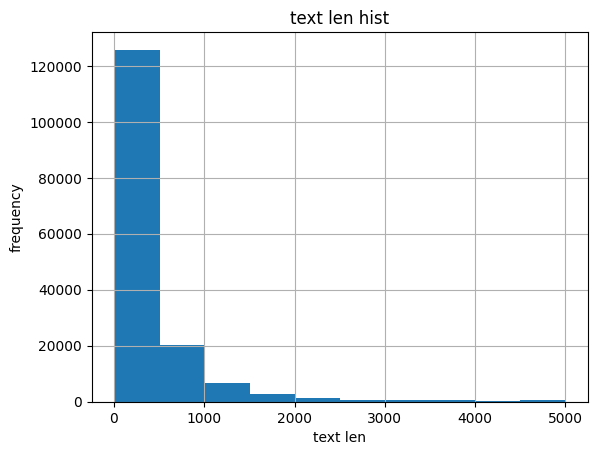

In [4]:
df['text'].apply(len).hist()
plt.title('text len hist')
plt.ylabel('frequency')
plt.xlabel('text len')
# plt.yscale('log')

dole = (df['text'].apply(len) <= 512).mean()
print(f'dole of text shorter that 512 chars {dole}')

Около 20% наблюдений превышают длину в 512 символов. Попробуем снизить этот показатель, оставив только буквенные символы латинницы.

In [5]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.split()
    text = ' '.join(text)
    return text

df['text'] = df['text'].apply(clear_text)

dole of text shorter that 512 chars 0.8057655123923361


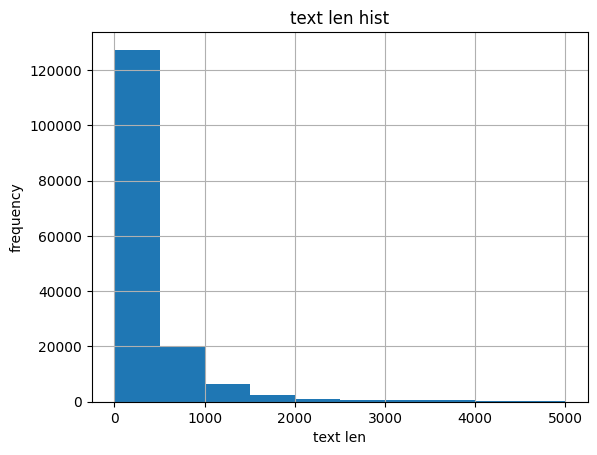

In [6]:
df['text'].apply(len).hist()
plt.title('text len hist')
plt.ylabel('frequency')
plt.xlabel('text len')
# plt.yscale('log')

dole = (df['text'].apply(len) <= 512).mean()
print(f'dole of text shorter that 512 chars {dole}')

Особой результативности это не принесло. Тогда остановимся на радикальной мере - ограничим значения первыми 512 символами.

In [7]:
df['text'] = df['text'].apply(lambda x: x[:512])

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
tokenized = df['text'].apply(
                       lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [9]:
# config = torch.hub.load('huggingface/pytorch-transformers', 'config', 'bert-base-uncased')
# model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-uncased', config=config)
model = torch.hub.load('unitaryai/detoxify','toxic_bert')

model.eval()
model.to(device)
print('###############')

Using cache found in /home/gin/.cache/torch/hub/unitaryai_detoxify_master


###############


In [10]:
batch_size = 128
embeddings = []
for i in notebook.tqdm(range(math.ceil(padded.shape[0] / batch_size))):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]).to(device)
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)]).to(device)

    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)

    # embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
    embeddings.append(batch_embeddings[0].cpu().numpy())
    
features = np.concatenate(embeddings)

  0%|          | 0/1245 [00:00<?, ?it/s]

## Обучение

In [11]:
X = features
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=y, random_state=42)

In [12]:
model_types = {
               'logreg': LogisticRegression(class_weight='balanced', random_state=42, n_jobs=-1),
               'lgbm': LGBMClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
              }

models_params = {
                 'logreg': {'C': [0.1, 1., 10],
                            'class_weight': ['balanced', None]},
                 'lgbm': {'class_weight': ['balanced', None]}
                }

In [13]:
%%time
best_models = {}
cv_results = {}

for model_type in model_types:
    model = model_types[model_type]
    grid = GridSearchCV(model, models_params[model_type], cv=5, scoring=['f1', 'f1_micro', 'f1_macro', 'f1_weighted'],
                        n_jobs=5, refit='f1_macro', return_train_score=False)
    
    grid.fit(X_train, y_train)
    best_models[model_type] = grid.best_estimator_
    cv_results[model_type] = grid.cv_results_
    print('Лучшая модель в группе {} имеет значение f1_macro - {:.2f} и параметры {}'\
          .format(model_type,\
                  grid.best_score_,\
                  grid.best_params_))
    print()

Лучшая модель в группе logreg имеет значение f1_macro - 0.95 и параметры {'C': 10, 'class_weight': None}

Лучшая модель в группе lgbm имеет значение f1_macro - 0.95 и параметры {'class_weight': None}

CPU times: user 2.61 s, sys: 1.76 s, total: 4.37 s
Wall time: 9.31 s


In [14]:
for model_type in cv_results:
    print(model_type)
    display(pd.DataFrame(cv_results[model_type])\
            [['mean_fit_time', 'mean_score_time',
              'mean_test_f1', 'mean_test_f1_micro',
              'mean_test_f1_macro', 'mean_test_f1_weighted',
              'params', 'rank_test_f1_macro']]\
            .sort_values('rank_test_f1_macro')
           )

logreg


,mean_fit_time,mean_score_time,mean_test_f1,mean_test_f1_micro,mean_test_f1_macro,mean_test_f1_weighted,params,rank_test_f1_macro
5,0.370337,0.030430,0.911629,0.982250,0.950881,0.982134,"{'C': 10, 'class_weight': None}",1
3,0.342001,0.036466,0.911600,0.982242,0.950865,0.982128,"{'C': 1.0, 'class_weight': None}",2
1,0.333191,0.037579,0.911592,0.982234,0.950858,0.982122,"{'C': 0.1, 'class_weight': None}",3
2,0.345096,0.037559,0.859240,0.967732,0.920509,0.969291,"{'C': 1.0, 'class_weight': 'balanced'}",4
4,0.337425,0.037172,0.859239,0.967732,0.920508,0.969291,"{'C': 10, 'class_weight': 'balanced'}",5
0,0.337379,0.038294,0.858897,0.967638,0.920310,0.969207,"{'C': 0.1, 'class_weight': 'balanced'}",6


lgbm


,mean_fit_time,mean_score_time,mean_test_f1,mean_test_f1_micro,mean_test_f1_macro,mean_test_f1_weighted,params,rank_test_f1_macro
1,0.422887,0.057276,0.909147,0.981716,0.949491,0.981613,{'class_weight': None},1
0,0.490624,0.071946,0.866991,0.969898,0.925009,0.971205,{'class_weight': 'balanced'},2


## Выводы

In [15]:
preds = best_models['logreg'].predict(X_test)
print(f"f1_binary score - {f1_score(y_test, preds, average='binary'):.2f}")
print(f"f1_micro score - {f1_score(y_test, preds, average='micro'):.2f}")
print(f"f1_macro score - {f1_score(y_test, preds, average='macro'):.2f}")
print(f"f1_weighted score - {f1_score(y_test, preds, average='weighted'):.2f}")

f1_binary score - 0.91
f1_micro score - 0.98
f1_macro score - 0.95
f1_weighted score - 0.98


[1.14529597]


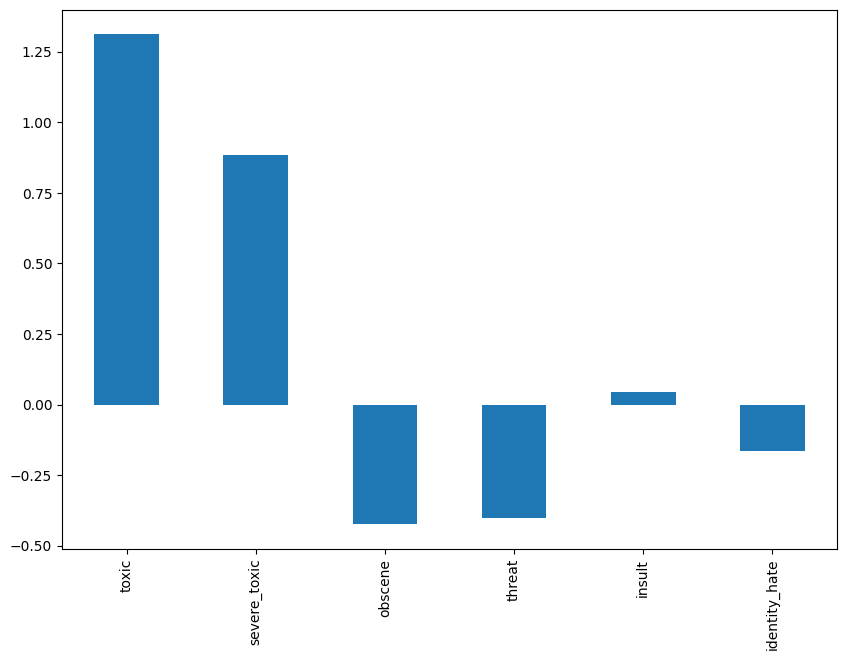

In [16]:
plt.figure(figsize=(10, 7))
pd.Series(best_models['logreg'].coef_[0], index=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']).plot(kind='bar')
print(best_models['logreg'].intercept_)

Bert-toxic, предсказывает токсичность комментариев по мультиклассу ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate') и, как несложно заметить, 'toxic' и 'severe_toxic' имеют высокие веса, в то время как другие типы "недоброжелательного поведения" имеют гораздо более скромные по модулю коэффициены. Как мы можем заметить, мульклассовые f1 метрики на тестовой выборке демонстрируют крайне высокое значение параметров (> 0.90). Целевое значение метрики f1 в 0.75 также достигнуто.